## Load data from file

In [94]:
%matplotlib notebook

import numpy as np
with np.load('dimredux-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    validation_x = fh['validation_x']
    validation_y = fh['validation_y']
# TRAINING DATA:
print(data_x.shape, data_x.dtype)
# VALIDATION DATA:
print(validation_x.shape, validation_x.dtype)
print(validation_y.shape, validation_y.dtype)
# TRAIN MODEL ON data_x
# VALIDATE ON validation_x and validation_y
# PREDICT prediction FROM data_x

(100000, 3) float64
(1000, 3) float64
(1000,) int32


## Plot data in three dimensions

In [55]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


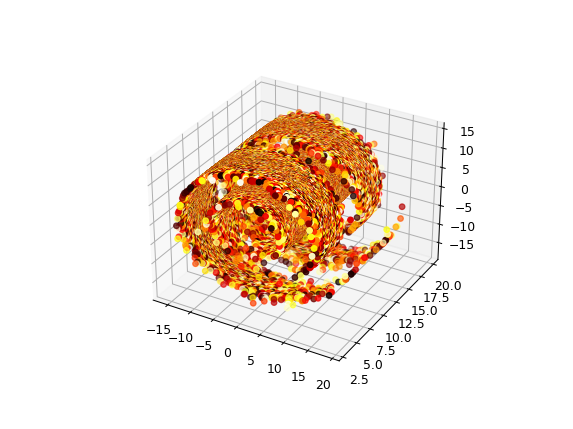

In [56]:
# plot all points (over time) in one plot
def plot_data_time(data):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    time = np.arange(data[:,0].size)
    ax.scatter3D(data[:,0],data[:,1],data[:,2],c=time,cmap=plt.hot())

plot_data_time(data_x)

## Plot density of data

<IPython.core.display.Javascript object>


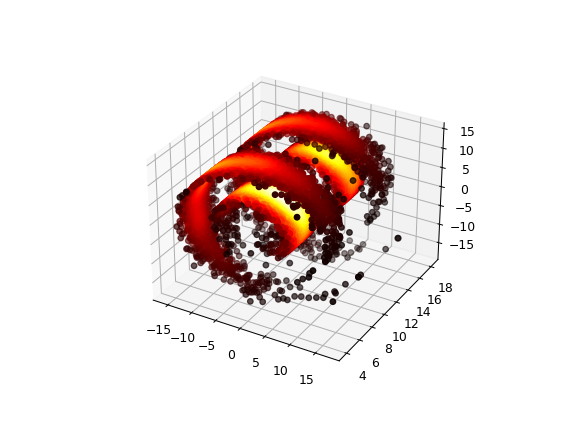

In [57]:
# plot the first 100 points (over time) in one plot and color according to density

from scipy.stats import gaussian_kde

def plot_data_density(data):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    xyz = np.vstack([data[:,0],data[:,1],data[:,2]])
    density = gaussian_kde(xyz)(xyz)
    
    ax.scatter3D(data[:,0],data[:,1],data[:,2],c=density,cmap=plt.hot())

plot_data_density(data_x[:10000])

## Plot validation data

<IPython.core.display.Javascript object>


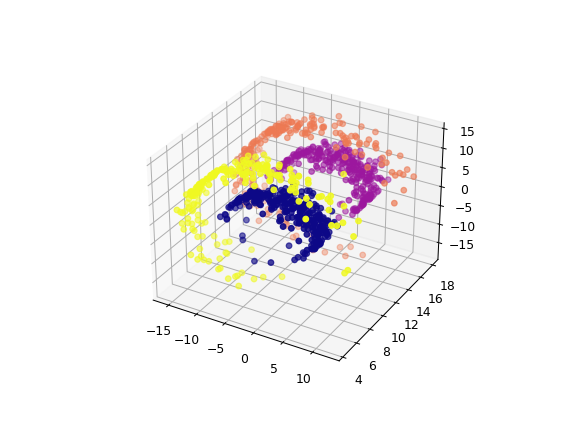

In [71]:
def plot_labels(data,labels,cmap='plasma'):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(data[:,0],data[:,1],data[:,2],c=labels,cmap=cmap)

plot_labels(validation_x,validation_y)

## Plot data over time

<IPython.core.display.Javascript object>


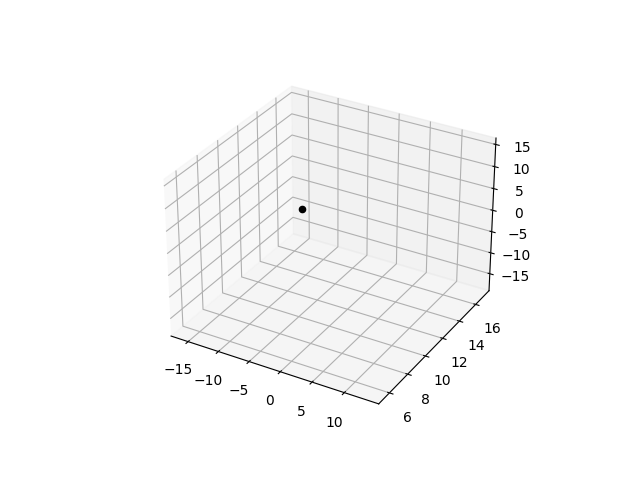

In [46]:
# the point is often behind the density plot and can not be seen. This can not be fixed (there is an matplotlib issue for that)

fig = plt.figure()
ax = plt.axes(projection='3d')
points_in_time=[]
m_points=100
n_density=1000

for data_point in data_x[:m_points]:
    points_in_time.append([ax.scatter3D(data_point[0],data_point[1],data_point[2],c='Black',zorder=2)])

ani = animation.ArtistAnimation(fig, points_in_time, interval=200, blit=True,repeat=False)

plt.show()

# Prepare data

## Split to X and Y

In [58]:
tau = 25
T = len(data_x)
train_x_raw = data_x[:T-tau]
train_y_raw = data_x[tau:]

## Remove mean values

In [59]:
def zero_mean(data):
    mean = data.mean(axis=0)
    zero_mean_data=data-mean[np.newaxis,:]
    return zero_mean_data,mean

train_x,x_mean = zero_mean(train_x_raw)
train_y,y_mean = zero_mean(train_y_raw)

<IPython.core.display.Javascript object>


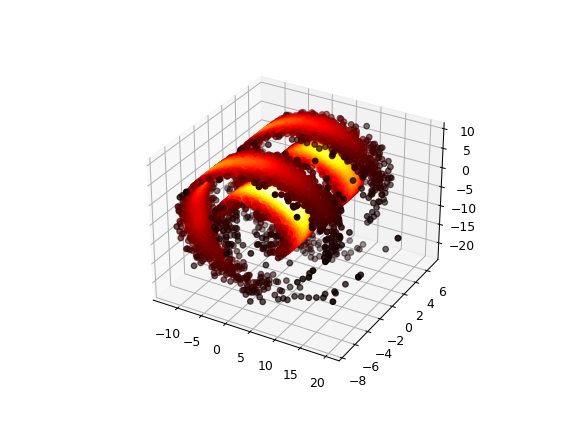

In [60]:
plot_data_density(train_x[:10000])

## Rotate and whiten the data

In [61]:
import numpy.linalg as linalg

def whiten(data):
    # compute covariance matrix (normalized by len(train_x)=T-tau)
    cov = np.cov(data, rowvar=False, bias=True) # same result as np.dot(train_x.transpose(),train_x)/len(train_x)

    # Eigenvalue decomposition
    eigenvalues, eigenvectors= linalg.eig(cov)

    # Decorrelate data by transposing using eigenvectors (this is PCA)
    data_rotated = np.dot(data,eigenvectors)
    
    # Whiten (by dividing by eigenvalues)
    data_whitened = np.dot(data_rotated,np.diag(1/(eigenvalues**0.5)))

    return data_whitened, data_rotated, cov, eigenvalues, eigenvectors

train_x_whitened, x_rotated, cov_xx, x_eigenvalues, x_eigenvectors = whiten(train_x)
train_y_whitened, y_rotated, cov_yy, y_eigenvalues, y_eigenvectors = whiten(train_y)

## Plot rotated data 

<IPython.core.display.Javascript object>


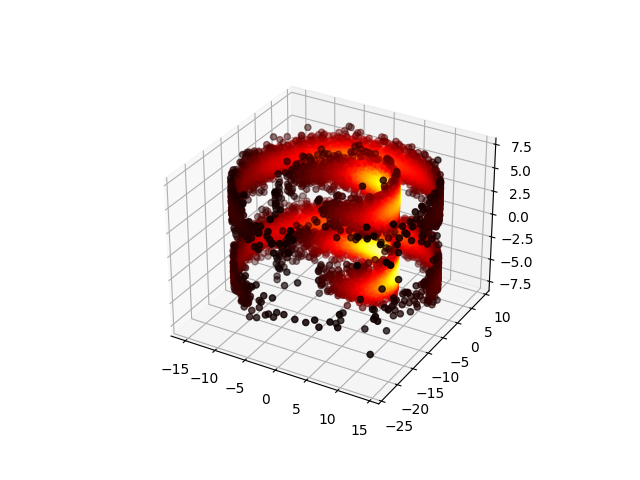

In [11]:
plot_data_density(x_rotated[:10000])

## Plot whitened data

<IPython.core.display.Javascript object>


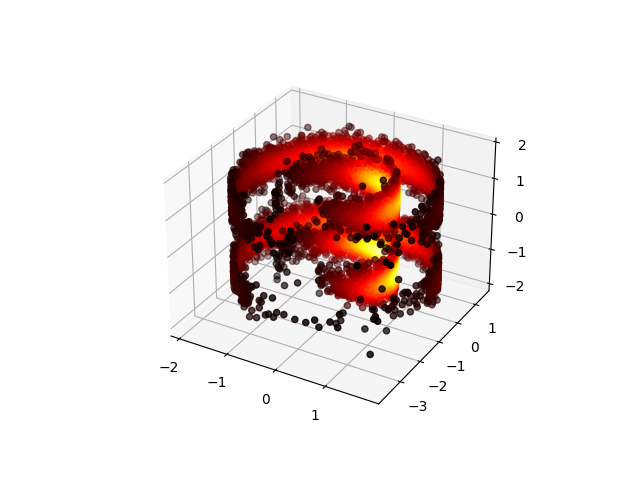

In [25]:
plot_data_density(train_x_whitened[:10000])

## Reconstruct data from whitened data

<IPython.core.display.Javascript object>


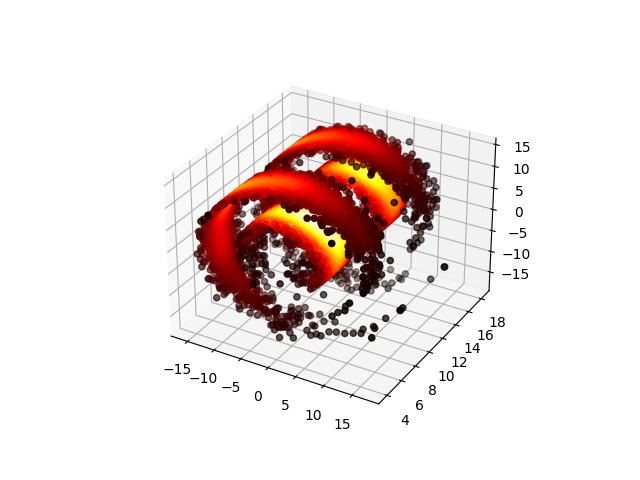

In [13]:
train_x_rotated_rec = np.dot(train_x_whitened, np.diag(x_eigenvalues**0.5))
train_x_rec = np.dot(train_x_rotated_rec, linalg.inv(x_eigenvectors))
train_x_raw_rec = train_x_rec+x_mean
plot_data_density(train_x_raw_rec[:10000])

## Choose tau

<IPython.core.display.Javascript object>


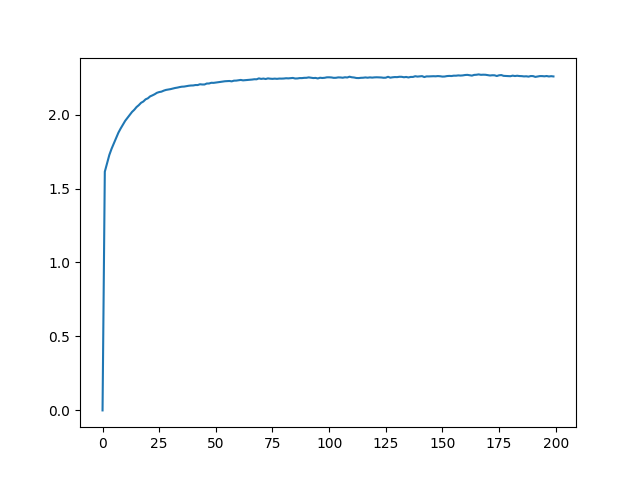

In [42]:
def get_tau_difference(x,tau):
    T = len(x)
    x_test = x[:T-tau]
    y_test = x[tau:]
    distance=np.linalg.norm(x_test - y_test,axis=1)
    return distance.mean()

distances=[]
tau_values=np.arange(200)

for tau in tau_values:
    distance=get_tau_difference(train_x_whitened,tau)
    distances.append(distance)
    
fig=plt.figure()
plt.plot(tau_values,distances)

Looks like tau = 25 could be good

# Define and train the model

## Define the model

In [62]:
from torch import nn

class Autoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=3, out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50, out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50, out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh())
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=1,out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4,out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50,out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50,out_features=3))

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return reconstructed
    
    def encode(self,x):
        code = self.encoder(x)
        return code

autoencoder=Autoencoder()

## Prepare Dataloader for training

In [63]:
import torch
from torch.utils.data import TensorDataset

batch_size=64

x_tensor=torch.Tensor(train_x_whitened)
y_tensor=torch.Tensor(train_y_whitened)
train_data=TensorDataset(x_tensor,y_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size)

## Define Loss function and optimizer

In [64]:
import torch.optim as optim

loss_fn = nn.MSELoss() #Mean squared error because it's an regression problem
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## Train the network

50 epochs give a pretty good result. Just run the training as often as you please. However for some reason the loss doesn't seem to get better. 

In [65]:
overall_epochs=0

In [101]:
epochs = 30
print_per_epoch=3
print_running_loss = int((T-tau)/(print_per_epoch*batch_size))

for epoch in range(epochs):  # loop over the dataset multiple times
    overall_epochs+=1
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        x, y = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_running_loss == print_running_loss-1:    # print 10 times during an epoch
            print('[epoch %d, iterations: %5d] loss: %.3f' %
                  (overall_epochs + 1, i + 1, running_loss / print_running_loss))
            running_loss = 0.0
print('Finished Training')

[epoch 32, iterations:   520] loss: 0.991
[epoch 32, iterations:  1040] loss: 0.980
[epoch 32, iterations:  1560] loss: 0.972
[epoch 33, iterations:   520] loss: 0.991
[epoch 33, iterations:  1040] loss: 0.980
[epoch 33, iterations:  1560] loss: 0.972
[epoch 34, iterations:   520] loss: 0.991
[epoch 34, iterations:  1040] loss: 0.980
[epoch 34, iterations:  1560] loss: 0.972
[epoch 35, iterations:   520] loss: 0.991
[epoch 35, iterations:  1040] loss: 0.980
[epoch 35, iterations:  1560] loss: 0.972
[epoch 36, iterations:   520] loss: 0.991
[epoch 36, iterations:  1040] loss: 0.980
[epoch 36, iterations:  1560] loss: 0.972
[epoch 37, iterations:   520] loss: 0.991
[epoch 37, iterations:  1040] loss: 0.980
[epoch 37, iterations:  1560] loss: 0.972
[epoch 38, iterations:   520] loss: 0.991
[epoch 38, iterations:  1040] loss: 0.980
[epoch 38, iterations:  1560] loss: 0.972
[epoch 39, iterations:   520] loss: 0.991
[epoch 39, iterations:  1040] loss: 0.980
[epoch 39, iterations:  1560] loss

## Plot reconstruced Data

<IPython.core.display.Javascript object>


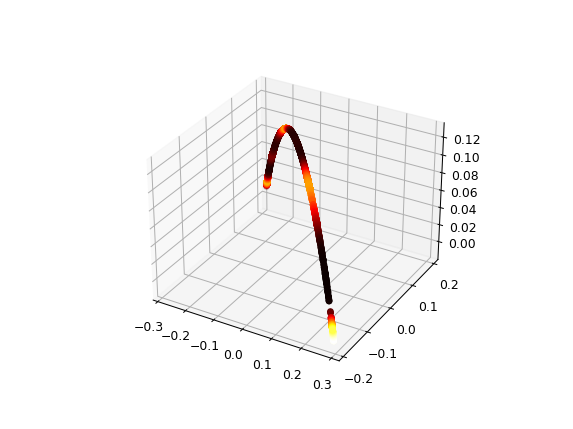

In [102]:
with torch.no_grad():
    reconstructed=autoencoder(x_tensor)
    plot_data_density(reconstructed[:10000])

## Plot the training data with predicted classification

<IPython.core.display.Javascript object>


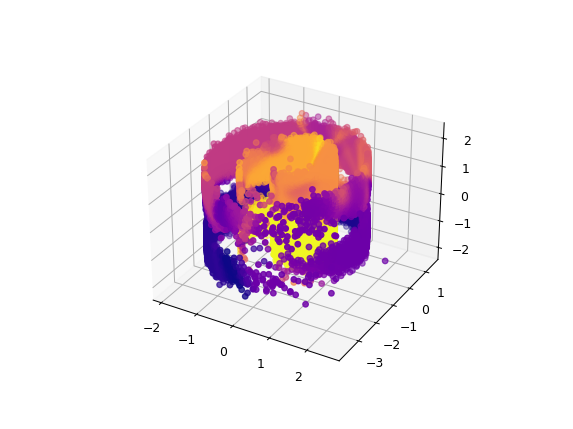

In [103]:
with torch.no_grad():
    train_codes = autoencoder.encode(x_tensor).numpy()[:,0]
    
plot_labels(train_x_whitened,train_codes)

## Histogram of the codes

<IPython.core.display.Javascript object>


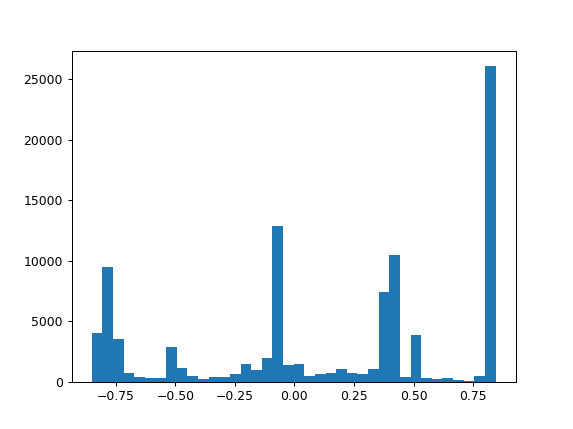

In [104]:
fig = plt.figure()
plt.hist(train_codes, bins='auto')
plt.show()

## Get labels from 0 to 3 and plot prediction

<IPython.core.display.Javascript object>


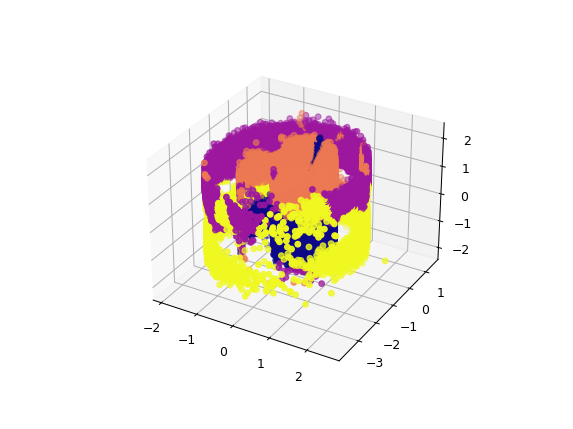

In [105]:
from sklearn.cluster import KMeans

def cluster_labels(codes):
    cluster=KMeans(4).fit(codes.reshape(-1, 1))
    return cluster.labels_
plot_labels(train_x_whitened,cluster_labels(train_codes))

## Check validation data

<IPython.core.display.Javascript object>


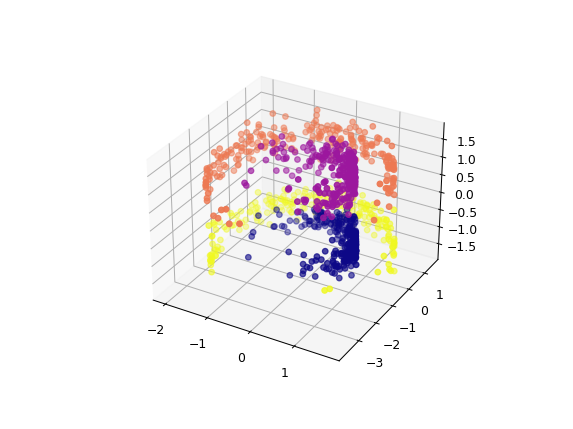

<IPython.core.display.Javascript object>


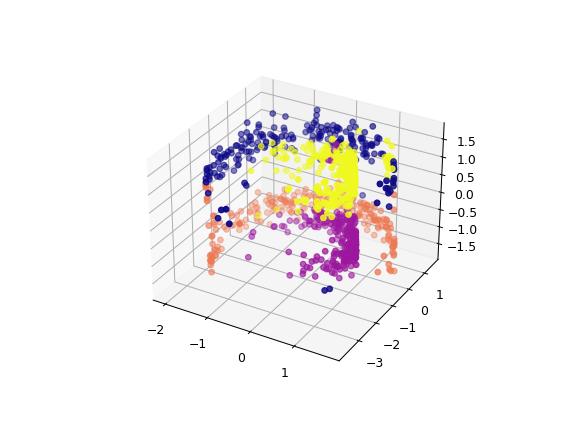

In [106]:
val_x,val_x_mean = zero_mean(validation_x)
val_x_whitened=whiten(val_x)[0]
plot_labels(val_x_whitened,validation_y,'plasma')

with torch.no_grad():
    val_codes = autoencoder.encode(torch.Tensor(val_x_whitened)).numpy()[:,0]
    val_codes=cluster_labels(val_codes)

plot_labels(val_x_whitened,val_codes,'plasma')

## Get Validation accuracy

In [107]:
import itertools

permutations=tuple(itertools.permutations((0,1,2,3)))
accuracies = []

for permutation in permutations:
    permutated_solution=[permutation[code-1] for code in validation_y]
    correct_predictions=(permutated_solution == val_codes)
    accuracies.append(sum(correct_predictions)/len(validation_y))

print(max(accuracies))

0.952


## Get classificion for full training data

<IPython.core.display.Javascript object>


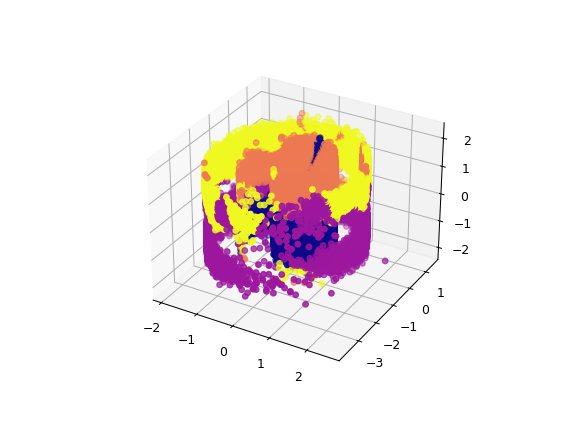

In [108]:
full_x,full_x_mean = zero_mean(data_x)
full_x_whitened=whiten(full_x)[0]

with torch.no_grad():
    pred_codes = autoencoder.encode(torch.Tensor(full_x_whitened)).numpy()[:,0]
    prediction=cluster_labels(pred_codes)

plot_labels(full_x_whitened,prediction)

## Check the prediction format and save

In [109]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 100000
# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))
# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (100000, )
    assert loaded.dtype == int
    assert (loaded <= 3).all()
    assert (loaded >= 0).all()
validate_prediction_format()